In [7]:
import time

import IPython.display as IPd
import matplotlib as mpl
import matplotlib.pylab as plt
import numpy as np
import torch
from mpl_toolkits.axes_grid1 import make_axes_locatable

import stg_energy.fig3_amortize_energy.viz as viz
from pyloric import create_prior, get_time, simulate_energyscape, stats
from sbi.utils.regression_net.get_nn_classifier import classifier
from sbi.utils.regression_net.train_classifier import fit_regression_net
from stg_energy.common import col, get_labels_8pt, svg
from stg_energy.fig3_amortize_energy.helper_functions import (
    active_subspace,
    get_gradient,
)

# Figure 3: additional nets
Here, we train 3 nets to predict the energy in AB/PD, LP, and PY. This will be used in fig5_cc

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
PANEL_A = "../svg/panel_a.svg"
PANEL_B = "../svg/panel_b.svg"
PANEL_C = "../svg/panel_c.svg"
PANEL_REG_A1 = "../svg/panel_reg_a1.svg"
PANEL_REG_A2 = "../svg/panel_reg_a2.svg"
PANEL_REG_B = "../svg/panel_reg_b.svg"
PANEL_REG_C = "../svg/panel_reg_c.svg"
PANEL_REG_D1 = "../svg/panel_reg_d1.svg"
PANEL_REG_D2 = "../svg/panel_reg_d2.svg"
PANEL_REG_D3 = "../svg/panel_reg_d3.svg"
PANEL_REG_D4 = "../svg/panel_reg_d4.svg"
PANEL_REG_E = "../svg/panel_reg_e.svg"
PANEL_REG_F = "../svg/panel_reg_f.svg"
PANEL_REG_G = "../svg/panel_reg_g.svg"
PANEL_REG_H = "../svg/panel_reg_h.svg"
PANEL_REG_G2 = "../svg/panel_reg_g2.svg"
PANEL_REG_H2 = "../svg/panel_reg_h2.svg"

### Load experimental data

In [10]:
prior_11 = create_prior(log=True)
dimensions_11 = 31
lims_11 = np.asarray(
    [-np.sqrt(3) * np.ones(dimensions_11), np.sqrt(3) * np.ones(dimensions_11)]
).T

params_mean_11 = prior_11.mean.numpy()
params_std_11 = prior_11.stddev.numpy()

In [11]:
data = np.load("../../results/11deg_post_pred/11_deg_post_pred_close_to_obs.npz")
good_stats = data["sample_stats"]
good_params = data["sample_params"]
good_seeds = data["sample_seeds"]

In [12]:
sample_params = good_params
sample_stats = good_stats
print("There are", len(good_seeds), "datapoints in this dataset")

There are 55043 datapoints in this dataset


In [13]:
sample_stats = data["sample_stats"]
sample_params = data["sample_params"]
sample_seeds = data["sample_seeds"]

In [14]:
energies = sample_stats[:, 21:24]
summed_energies = np.sum(energies, axis=1)

### Quantify the variances

In [15]:
prior_range = (prior_11.support.upper_bound - prior_11.support.lower_bound).numpy()

In [16]:
inds = np.argsort(summed_energies)
sorted_energies = np.sort(summed_energies)
sorted_params = sample_params[inds]
sorted_ss = sample_stats[inds]

In [17]:
all_means = []
for quantile in [0.99, 0.75, 0.5, 0.25, 0.01]:

    sample_stats = data["sample_stats"]
    sample_params = data["sample_params"]
    sample_seeds = data["sample_seeds"]

    num_samples = 1000
    num_vals = len(summed_energies)
    params_to_plot = sorted_params[
        int(num_vals * quantile - num_samples / 2) : int(
            num_vals * quantile + num_samples / 2
        )
    ]
    energy_thr = sorted_energies[int(num_vals * quantile)]

    mean_of_these_params = np.mean(params_to_plot, axis=0)
    all_means.append(mean_of_these_params)
all_means = np.asarray(all_means)

In [18]:
energy_thr

1721441.8802888643

### Plot histogram

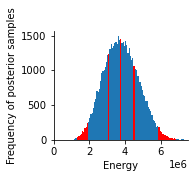

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(2.4, 2))

N, bins, patches = ax.hist(summed_energies, bins=100)

for quantile in [0.99, 0.75, 0.5, 0.25, 0.01]:
    sample_stats = data["sample_stats"]
    sample_params = data["sample_params"]
    sample_seeds = data["sample_seeds"]

    num_samples = 1000
    num_vals = len(summed_energies)
    params_to_plot = sorted_params[
        int(num_vals * quantile - num_samples / 2) : int(
            num_vals * quantile + num_samples / 2
        )
    ]
    energy_thr_low = sorted_energies[int(num_vals * quantile - num_samples / 2)]
    energy_thr_high = sorted_energies[int(num_vals * quantile + num_samples / 2)]

    for i, b in enumerate(bins):
        if b > energy_thr_low and b < energy_thr_high:
            patches[i].set_facecolor("r")

ax.set_xlim(0, 7500000)
ax.set_xlabel("Energy")
ax.set_ylabel("Frequency of posterior samples")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# plt.savefig('../results/energy/figs_new/histogram.png', dpi=300, bbox_inches='tight')

In [20]:
shift_in_mean = all_means[0] - all_means[-1]
shift_in_mean_normalized = shift_in_mean / prior_range

In [21]:
sort_inds = np.argsort(np.abs(shift_in_mean_normalized))
strongest_variation_inds = np.sort(sort_inds[-8:])  # these are used for plots

In [22]:
labels_ = get_labels_8pt()
labels_[9] += ""

In [23]:
from decimal import Decimal

all_labels = []
lims = lims_11
params_std = params_std_11
params_mean = params_mean_11
for dim_i in range(31):
    if dim_i > len(params_mean_11) - 7.5:  # synapses
        if dim_i == 24:
            all_labels.append(
                [r"$\mathdefault{0.01}$     ", r"$\mathdefault{10000}\;\;\;\;$   "]
            )
        else:
            all_labels.append(
                [r"$\mathdefault{0.01}$ ", r"$\mathdefault{1000}\;\;\;\;$ "]
            )
    else:  # membrane conductances
        num_after_digits = -int(
            np.log10(lims[dim_i, 1] * params_std[dim_i] + params_mean[dim_i])
        )
        if num_after_digits > 2:
            num_after_digits = 2
        labels = [
            round(
                Decimal(
                    (lims[dim_i, num_tmp] * params_std[dim_i] + params_mean[dim_i])
                    / 0.628e-3
                ),
                num_after_digits,
            )
            for num_tmp in range(2)
        ]
        new_labels = []
        counter = 0
        for l in labels:
            if counter == 0:
                new_labels.append(r"$\mathdefault{" + str(l) + "}$  ")
            else:
                new_labels.append(r"$\mathdefault{" + str(l) + "}\;\;\;$  ")
            counter += 1
        all_labels.append(new_labels)

# Panel 0: Fit regression net

In [24]:
energies = torch.as_tensor(energies)
sample_stats = torch.as_tensor(sample_stats)

In [25]:
print(energies.shape)

torch.Size([55043, 3])


In [26]:
num_test = 500

test_params = good_params[:num_test]
train_params = good_params[num_test:]
mean_params = np.mean(train_params, axis=0)
std_params = np.std(train_params, axis=0)

train_params_norm = (train_params - mean_params) / std_params
test_params_norm = (test_params - mean_params) / std_params

### AB/PD

In [43]:
train_energy_ABPD = energies[num_test:, 0].unsqueeze(1)
test_energy_ABPD = energies[:num_test, 0].unsqueeze(1)
mean_energy = torch.mean(train_energy_ABPD)
std_energy = torch.std(train_energy_ABPD)
train_energy_ABPD_norm = (train_energy_ABPD - mean_energy) / std_energy
test_energy_ABPD_norm = (test_energy_ABPD - mean_energy) / std_energy

In [44]:
nn = classifier(dim=31)

In [45]:
converged_nn = fit_regression_net(
    nn,
    train_params_norm,
    train_energy_ABPD_norm,
    num_train=train_params_norm.shape[0],
    batch_size=50,
    stop_after_epochs=10,
    max_epochs=200,
)
np.savez('../../results/regression_nets/201007_predict_total_energy_ABPD.npz', converged_nn=converged_nn, mean_params=mean_params, std_params=std_params, mean_energy=mean_energy, std_energy=std_energy)

Total number of trainable parameters 169001
Training loss   0.0024701463387346544
validation loss 0.0008987268660043381
Training loss   0.0010592765318238294
validation loss 0.0006617953384501687
Training loss   0.0007933264820722042
validation loss 0.0005149087516077061
Training loss   0.0006942612797589827
validation loss 0.0004975700392417685
Training loss   0.0006159773559788863
validation loss 0.0004282528297219333
Training loss   0.0005756694181246083
validation loss 0.0004232845531211437
Training loss   0.0005449943847858956
validation loss 0.0003854897482735536
Training loss   0.0005143139853572954
validation loss 0.0003544431934380728
Training loss   0.0004950413541720192
validation loss 0.0003858382819607977
Training loss   0.00048543369500959145
validation loss 0.00035472796115030615
Training loss   0.0004678096998187882
validation loss 0.0003369252367319042
Training loss   0.0004572099554118721
validation loss 0.0003338536469557764
Training loss   0.0004440778439718504
vali

In [46]:
data = np.load(
    "../../results/regression_nets/201007_predict_total_energy_ABPD.npz",
    allow_pickle=True,
)
converged_nn = data["converged_nn"].tolist()

In [47]:
predictions = converged_nn.predict(torch.as_tensor(test_params_norm)).detach()

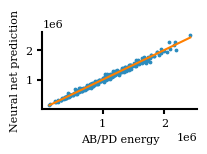

In [48]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2, 1.0))
    unnorm_x = test_energy_ABPD_norm[:300] * std_energy + mean_energy
    unnorm_y = predictions[:300] * std_energy + mean_energy
    ax.scatter(x=unnorm_x.numpy(), y=unnorm_y.numpy(), s=3, color="#2b8cbe")
    gt_vec = np.linspace(np.min(unnorm_x.numpy()), np.max(unnorm_x.numpy()), 2)
    ax.plot(gt_vec, gt_vec, "#ff7f00")
    ax.set_xlabel("AB/PD energy")
    ax.set_ylabel("Neural net prediction")

### LP

In [49]:
nn = classifier(dim=31)

In [50]:
train_energy_ABPD = energies[num_test:, 1].unsqueeze(1)
test_energy_ABPD = energies[:num_test, 1].unsqueeze(1)
mean_energy = torch.mean(train_energy_ABPD)
std_energy = torch.std(train_energy_ABPD)
train_energy_ABPD_norm = (train_energy_ABPD - mean_energy) / std_energy
test_energy_ABPD_norm = (test_energy_ABPD - mean_energy) / std_energy

In [51]:
converged_nn = fit_regression_net(
    nn,
    train_params_norm,
    train_energy_ABPD_norm,
    num_train=train_params_norm.shape[0],
    batch_size=50,
    stop_after_epochs=10,
    max_epochs=200,
)
np.savez('../../results/regression_nets/201007_predict_total_energy_LP.npz', converged_nn=converged_nn)

Total number of trainable parameters 169001
Training loss   0.0031469269285908617
validation loss 0.0010503784829356275
Training loss   0.001409336614921553
validation loss 0.0007759686296517209
Training loss   0.0011060385183295214
validation loss 0.0006895094952869591
Training loss   0.0009699744643140196
validation loss 0.0006206545917322393
Training loss   0.0008883743199782089
validation loss 0.0006299218996048083
Training loss   0.0008300184882385596
validation loss 0.0005549944028954895
Training loss   0.0007709063818912608
validation loss 0.000559623667493968
Training loss   0.0007518824653627444
validation loss 0.0004923356090878042
Training loss   0.0007196638339544881
validation loss 0.0005005355856076606
Training loss   0.0006804600213590592
validation loss 0.0005091515080328932
Training loss   0.0006755830620954632
validation loss 0.00044453893160732597
Training loss   0.0006500851879223593
validation loss 0.0004385940686182403
Training loss   0.0006337203349709581
validat

In [52]:
data = np.load(
    "../../results/regression_nets/201007_predict_total_energy_LP.npz",
    allow_pickle=True,
)
converged_nn = data["converged_nn"].tolist()

In [53]:
predictions = converged_nn.predict(torch.as_tensor(test_params_norm)).detach()

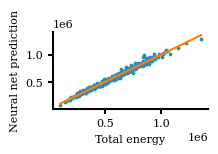

In [54]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2, 1.0))
    unnorm_x = test_energy_ABPD_norm[:300] * std_energy + mean_energy
    unnorm_y = predictions[:300] * std_energy + mean_energy
    ax.scatter(x=unnorm_x.numpy(), y=unnorm_y.numpy(), s=3, color="#2b8cbe")
    gt_vec = np.linspace(np.min(unnorm_x.numpy()), np.max(unnorm_x.numpy()), 2)
    ax.plot(gt_vec, gt_vec, "#ff7f00")
    ax.set_xlabel("Total energy")
    ax.set_ylabel("Neural net prediction")

# PY

In [55]:
nn = classifier(dim=31)

In [56]:
train_energy_ABPD = energies[num_test:, 2].unsqueeze(1)
test_energy_ABPD = energies[:num_test, 2].unsqueeze(1)
mean_energy = torch.mean(train_energy_ABPD)
std_energy = torch.std(train_energy_ABPD)
train_energy_ABPD_norm = (train_energy_ABPD - mean_energy) / std_energy
test_energy_ABPD_norm = (test_energy_ABPD - mean_energy) / std_energy

In [57]:
converged_nn = fit_regression_net(
    nn,
    train_params_norm,
    train_energy_ABPD_norm,
    num_train=train_params_norm.shape[0],
    batch_size=50,
    stop_after_epochs=10,
    max_epochs=200,
)
np.savez('../../results/regression_nets/201007_predict_total_energy_PY.npz', converged_nn=converged_nn)

Total number of trainable parameters 169001
Training loss   0.0020436190659222173
validation loss 0.000680924508307474
Training loss   0.0007599113805257779
validation loss 0.0005652459836833855
Training loss   0.0006153447317649189
validation loss 0.0004523135006332157
Training loss   0.0005453138644198402
validation loss 0.00042878246749217746
Training loss   0.0005166825295469665
validation loss 0.00040085503761507196
Training loss   0.0004955978925683508
validation loss 0.0003798698692298285
Training loss   0.00047000339202752224
validation loss 0.0003631959446491614
Training loss   0.00045515883391352086
validation loss 0.0003614530711683191
Training loss   0.0004398854782700422
validation loss 0.0003609635717791226
Training loss   0.0004204397271422188
validation loss 0.00034701855994904405
Training loss   0.00041192500962696074
validation loss 0.0003288379160979273
Training loss   0.00040638426429488256
validation loss 0.0003252807497554804
Training loss   0.0003919292625642079


In [58]:
data = np.load(
    "../../results/regression_nets/201007_predict_total_energy_PY.npz",
    allow_pickle=True,
)
converged_nn = data["converged_nn"].tolist()

In [59]:
predictions = converged_nn.predict(torch.as_tensor(test_params_norm)).detach()

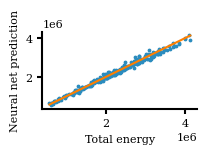

In [60]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2, 1.0))
    unnorm_x = test_energy_ABPD_norm[:300] * std_energy + mean_energy
    unnorm_y = predictions[:300] * std_energy + mean_energy
    ax.scatter(x=unnorm_x.numpy(), y=unnorm_y.numpy(), s=3, color="#2b8cbe")
    gt_vec = np.linspace(np.min(unnorm_x.numpy()), np.max(unnorm_x.numpy()), 2)
    ax.plot(gt_vec, gt_vec, "#ff7f00")
    ax.set_xlabel("Total energy")
    ax.set_ylabel("Neural net prediction")